# Exercise with A/B Testing

### Prompt

Let’s imagine you work on the For You Page at TikTok. Your team decides that instead of a heart button, they want to change it to star hoping that it will lead to a higher engagement/like rate. The product manager told you that the current conversion rate is about 6% on average throughout the year, and that the team would be happy with an increase of 3%, meaning that the new design will be considered a success if it raises the engagement rate to 9%.

Before rolling out the change, the team would be more comfortable testing it on a small number of users to see how it performs, so you suggest running an A/B test on a subset of the user base users.

In [1]:
# Packages imports
import numpy as np
import pandas as pd

# probability distributions & statistical functions
import scipy.stats as stats

# estimating statistical models
import statsmodels.stats.api as sms

import matplotlib.pyplot as plt
import seaborn as sns

#rounding function
from math import ceil


### Sample Size Calculation

In [2]:
# Calculate effect size based on our expected rates
effect_size = sms.proportion_effectsize(0.06, 0.09)    
print(effect_size)


required_n = sms.NormalIndPower().solve_power( 
    effect_size, 
    power=0.8, 
    alpha=0.05, 
    ratio=1)

-0.11445118168989943


In [3]:
# Calculate sample size needed

required_n = ceil(required_n)                                             
print(required_n)

1199


### Collecting and preparing the data

In [14]:
# Load the tiktok_data.csv into a dataframe

df = pd.read_csv('data/tiktok_data.csv')
df.head()

,user_id,timestamp,group,button,liked
0,767017,2017-01-12 22:58:15,control,star,0
1,793849,2017-01-23 22:36:11,treatment,star,0
2,905617,2017-01-20 14:12:19,treatment,star,0
3,746742,2017-01-23 11:38:30,control,heart,0
4,892356,2017-01-05 9:35:15,treatment,star,1


In [12]:
# Get the info of the dataframe

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275781 entries, 0 to 275780
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    275781 non-null  int64 
 1   timestamp  275781 non-null  object
 2   group      275781 non-null  object
 3   button     275781 non-null  object
 4   liked      275781 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 10.5+ MB


In [16]:
# Make sure all the control group are seeing the hearts button and viceversa

# pd.crosstab(df['group'], df['button'] ) #most control group sees hearts, treatment see mostly stars

df_control = df[(df['group'] == 'control')].copy() #grab all the control group
df_control = df_control[df['button'] != 'star'].copy() #select all control group that does not see stars 

df_treat = df[df['group'] == 'treatment'].copy() #grab all the treatment group
df_treat = df_treat[df['button'] != 'heart'].copy() #select all treatment group that does not see hearts

df_clean = pd.concat([df_control, df_treat], ignore_index=True) #put those two groups together
df = df_clean.copy() #replace old_df with new_df
df.shape

/var/folders/hh/qk4l6xwd65q9lfgxhl3nkd4w0000gn/T/ipykernel_1437/1248117094.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_control = df_control[df['button'] != 'star'].copy() #select all control group that does not see stars
/var/folders/hh/qk4l6xwd65q9lfgxhl3nkd4w0000gn/T/ipykernel_1437/1248117094.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_treat = df_treat[df['button'] != 'heart'].copy() #select all treatment group that does not see hearts


(272110, 5)

In [17]:
# Check that no users have been sampled multiple times 

session_count = df['user_id'].value_counts()
multi_user = session_count[session_count > 1].count()
print(multi_user)

1


In [18]:
# If there are users who have been sampled multiple times, remove them from the dataframe

print(df.shape)

users_to_drop = session_count[session_count > 1].index

df = df[~df['user_id'].isin(users_to_drop)]

print(df.shape)

(272110, 5)
(272108, 5)


#### Now that our DataFrame is nice and clean, we can proceed and sample n=4720 entries for each of the groups. We can use pandas' DataFrame.sample() method to do this, which will perform Simple Random Sampling for us.

In [19]:
# Perform simple random sampling to split the data into control and treatment
pd.crosstab(df['group'], df['button'])


button,heart,star
group,,
control,136002,0
treatment,0,136106


In [22]:
# Create one table called ab_test that has both the cleaned control and treatment data
control_group = df[df['group'] == 'control'].sample(n=required_n, random_state=444)
treatment_group = df[df['group'] == 'treatment'].sample(n=required_n, random_state=444)

ab_test = pd.concat([control_group, treatment_group], axis=0)
ab_test.reset_index(drop=True, inplace=True)
ab_test

,user_id,timestamp,group,button,liked
0,743360,2017-01-04 23:12:43,control,heart,0
1,781031,2017-01-04 7:32:58,control,heart,0
2,726048,2017-01-24 7:42:28,control,heart,0
3,852931,2017-01-09 0:34:11,control,heart,0
4,709201,2017-01-04 23:03:53,control,heart,0
...,...,...,...,...,...
2393,769236,2017-01-12 8:32:44,treatment,star,0
2394,644925,2017-01-19 8:18:56,treatment,star,0
2395,836678,2017-01-11 0:36:05,treatment,star,0
2396,882459,2017-01-13 17:27:09,treatment,star,0


In [25]:
# Count the test groups to make sure that they're balanced 

ab_test['group'].value_counts()

control      1199
treatment    1199
Name: group, dtype: int64

### Analysis Visualization

In [27]:
#Find the like rate by group
summary_stats = ab_test.groupby('group')['liked'].agg(['std', 'mean', 'sem', 'sum', 'count'])
summary_stats = summary_stats.reset_index()
summary_stats

# Find the Std. deviation of the proportion
# control ~ 0.337
# treatment ~ 0.315

# Find the Std. error of the proportion (std / sqrt(n))
# control ~ 0.0097
# treatment ~ 0.0091

# Calculate the final like rate


,group,std,mean,sem,sum,count
0,control,0.336563,0.130108,0.009720,156,1199
1,treatment,0.315202,0.111760,0.009103,134,1199


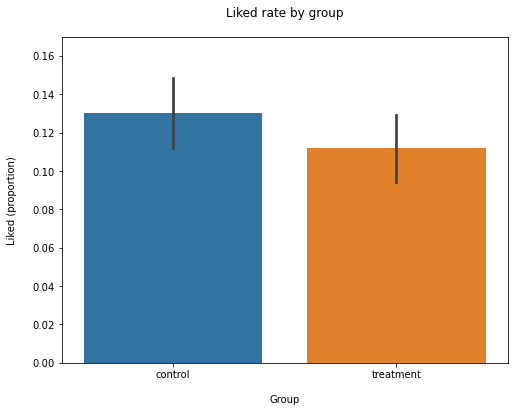

In [46]:
# Plot the like rate by group on a bar plot

plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['group'], y=ab_test['liked'])

plt.ylim(0, 0.17)

plt.title('Liked rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Liked (proportion)', labelpad=15);

### Testing for Stat Sig

In [50]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

# Get the like count for both control and treatment groups
control_results = ab_test[ab_test['group'] == 'control']['liked']
treatment_results = ab_test[ab_test['group'] == 'treatment']['liked']

n_con = control_results.count()
n_treat = treatment_results.count()

# Get the number of samples in both groups
nobs = [n_con, n_treat]

# Sum up the number of successes (likes) in both groups
successes = [control_results.sum(), treatment_results.sum()]

print(f"Likes from Control: {n_con} \nLikes from Treatment: {n_treat}")
print(f"Total samples: {nobs[0] + nobs[1]} ")
print(f"Success from Control: {successes[0]} \nSuccess from Treatment: {successes[1]}")

Likes from Control: 1199 
Likes from Treatment: 1199
Total samples: 2398 
Success from Control: 156 
Success from Treatment: 134


In [51]:
# Find the z statistic and p value for proportions based on normal ztest
z_stat, pval = proportions_ztest(
    successes,
    nobs=nobs)

# Find the confidence intervals for each test group
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.5)


In [53]:
# print z statistic
print(f"Z Stats: {z_stat}")
# print p-value
print(f"P val: {pval}")
# print ci 95% for control group
print(f"ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]")
# print ci 95% for treatment group
print(f"ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]")


Z Stats: 1.3778849862263354
P val: 0.16823880110552658
ci 95% for control group: [0.124, 0.137]
ci 95% for treatment group: [0.106, 0.118]


### Were the results signficant? 

In [ ]:
#No our pval exceeded the 0.05 threshold, which means the 'treatment' 
#did not provide a significant result thus did not lead to higher
#engagement/likes

### What would you advise the engineering team to do moving forward?

In [ ]:
#Find a different shape to switch to if you really must change the heart button.
#Maybe instead of changing the shapes of the button, maybe reinstate the dislike button.